In [69]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.io.wavfile as wav
from speechpy.feature import mfcc
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from keras.utils import np_utils
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


**Load the data set**

In [23]:
FILEPATH = 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\dataset\\Audio_Speech_Actors_01-24\\'
dir_list = os.listdir(FILEPATH)

In [24]:
#get the paths
dirts = []
filepath_delete = True
for root, dirt,file in os.walk(FILEPATH):
    if filepath_delete == True:
        print(root, "hahaha")
        filepath_delete = False
    else:
        dirts.append(root)     

C:\Users\ZhaoY\Downloads\DL_Project\dataset\Audio_Speech_Actors_01-24\ hahaha


In [27]:
#get the files in every path
files = []
for dirt in dirts:
    for root, dt, file in os.walk(dirt):
        for fl in file:
            files.append(os.path.join(dirt,fl))  

In [28]:
files[1]

'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\dataset\\Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-01-02-01.wav'

In [29]:
filename = []
Actor = []
for file in files:
    filename.append(file.split('\\')[-1])
    Actor.append(file.split('\\')[-2])

In [30]:
filename[0]

'03-01-01-01-01-01-01.wav'

In [33]:
Actor[-1]

'Actor_24'

In [153]:
Modality = []
Vocal_channel = []
Emotion = []
Emotional_intensity = []
Statement = []
Repetition = []

for name in filename:
    Modality.append(name.split('-')[0])
    Vocal_channel.append(name.split('-')[1])
    Emotion.append(int(name.split('-')[2])-1)
    Emotional_intensity.append(name.split('-')[3])
    Statement.append(name.split('-')[4])
    Repetition.append(name.split('-')[5])

In [154]:
df = pd.DataFrame({'files': files, 
                   'modalities': Modality,
                   'vocal_channels': Vocal_channel, 
                   'emotions': Emotion,
                   'emotional_intensities': Emotional_intensity,
                   'statements': Statement,
                   'repetitiona': Repetition})

In [155]:
df.head(1)

,files,modalities,vocal_channels,emotions,emotional_intensities,statements,repetitiona
0,C:\Users\ZhaoY\Downloads\DL_Project\dataset\Au...,03,01,0,01,01,01


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 7 columns):
files                    1440 non-null object
modalities               1440 non-null object
vocal_channels           1440 non-null object
emotions                 1440 non-null int64
emotional_intensities    1440 non-null object
statements               1440 non-null object
repetitiona              1440 non-null object
dtypes: int64(1), object(6)
memory usage: 78.8+ KB


In [157]:
df.emotions.value_counts()

7    192
6    192
5    192
4    192
3    192
2    192
1    192
0     96
Name: emotions, dtype: int64

In [144]:
print(len(files))

1440


In [95]:
mean_signal_length = 0
signals = []
for fname in files:
    signal, fs = librosa.load(fname, sr=16000, mono=True)
    mean_signal_length += len(signal)
    signals.append(signal)
mean_signal_length = mean_signal_length/(len(files))

In [98]:
mean_signal_length = int(mean_signal_length) 
print(mean_signal_length)

59210


In [145]:
def get_feature_vector_from_mfcc(signal, mean_signal_length: int, flatten: bool) -> np.ndarray:
    """
    Make feature vector from MFCC for the given wav file.

    Args:
        file_path (str): path to the .wav file that needs to be read.
        flatten (bool) : Boolean indicating whether to flatten mfcc obtained.
        mfcc_len (int): Number of cepestral co efficients to be consider.

    Returns:
        numpy.ndarray: feature vector of the wav file made from mfcc.
    """
    #fs, signal = wav.read(file_path)
    #signal, fs = librosa.load(file_path, sr=16000, mono=True)
    s_len = len(signal)

    # pad the signals to have same size if lesser than required
    # else slice them    
    
    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem),
                        'constant', constant_values=0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
        
    # sample/frame = mean_signal_length*frame_length
    mel_coefficients = mfcc(signal, fs, frame_length=0.048, frame_stride=0.024, num_filters=30, num_cepstral=30, low_frequency=60, high_frequency=7600)
    if flatten:
        # Flatten the data
        mel_coefficients = np.ravel(mel_coefficients)
    return mel_coefficients

In [146]:
features = []
for signal in signals:
    features.append(get_feature_vector_from_mfcc(signal, mean_signal_length, flatten=False))

In [158]:
features[0]

array([[-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

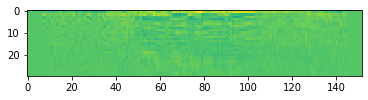

In [159]:
plt.imshow(features[0].T)

In [149]:
#need to stack these features, so need to add one demenssion
features = np.vstack([feature[np.newaxis, :, :] for feature in features])
features.shape

(1440, 152, 30)

In [160]:
np.unique(Emotion)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [161]:
#one hot code, it is classification not logistic regression, so change numbers to one hot code
labels = np_utils.to_categorical(Emotion)

In [162]:
labels.shape

(1440, 8)

In [163]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [170]:
def build_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.LSTM(128, input_shape=(input_shape[0], input_shape[1])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='tanh'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [171]:
model = build_model(input_shape=(features.shape[1], features.shape[2]), num_classes=8)

In [172]:
labels.shape

(1440, 8)

In [173]:
features.shape

(1440, 152, 30)

In [174]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', 
                               factor=0.2,
                               patience=5,
                               min_lr=1e-6,
                               verbose=1)

In [175]:
hist = model.fit(x_train, y_train, batch_size=32, epochs=34, validation_data=(x_test, y_test), callbacks=[lr_reducer])

Train on 1152 samples, validate on 288 samples
Epoch 1/100
1152/1152 [==============================] - 10s 9ms/sample - loss: 2.2722 - accuracy: 0.1363 - val_loss: 2.0548 - val_accuracy: 0.1354
Epoch 2/100
1152/1152 [==============================] - 7s 6ms/sample - loss: 2.0824 - accuracy: 0.1788 - val_loss: 1.9923 - val_accuracy: 0.2118
Epoch 3/100
1152/1152 [==============================] - 7s 6ms/sample - loss: 1.9788 - accuracy: 0.2361 - val_loss: 1.9676 - val_accuracy: 0.2674
Epoch 4/100
1152/1152 [==============================] - 6s 6ms/sample - loss: 1.9126 - accuracy: 0.2743 - val_loss: 1.9170 - val_accuracy: 0.3056
Epoch 5/100
1152/1152 [==============================] - 7s 6ms/sample - loss: 1.7924 - accuracy: 0.3134 - val_loss: 1.6904 - val_accuracy: 0.3924
Epoch 6/100
1152/1152 [==============================] - 7s 6ms/sample - loss: 1.6446 - accuracy: 0.3906 - val_loss: 1.6251 - val_accuracy: 0.4132
Epoch 7/100
1152/1152 [==============================] - 7s 6ms/sample

1152/1152 [==============================] - 7s 6ms/sample - loss: 0.2619 - accuracy: 0.9410 - val_loss: 1.0909 - val_accuracy: 0.6562
Epoch 51/100
1152/1152 [==============================] - 6s 6ms/sample - loss: 0.2784 - accuracy: 0.9358 - val_loss: 1.0908 - val_accuracy: 0.6562
Epoch 52/100
1152/1152 [==============================] - 6s 6ms/sample - loss: 0.2591 - accuracy: 0.9384 - val_loss: 1.0905 - val_accuracy: 0.6562
Epoch 53/100
1152/1152 [==============================] - 7s 6ms/sample - loss: 0.2733 - accuracy: 0.9418 - val_loss: 1.0908 - val_accuracy: 0.6562
Epoch 54/100
1152/1152 [==============================] - 7s 6ms/sample - loss: 0.2697 - accuracy: 0.9427 - val_loss: 1.0911 - val_accuracy: 0.6562
Epoch 55/100
1152/1152 [==============================] - 6s 6ms/sample - loss: 0.2745 - accuracy: 0.9323 - val_loss: 1.0915 - val_accuracy: 0.6562
Epoch 56/100
1152/1152 [==============================] - 7s 6ms/sample - loss: 0.2664 - accuracy: 0.9366 - val_loss: 1.0914 